# Aufgabenblatt 7

<p style="border-left:5px solid red;padding:0.6em;box-sizing:border-box;">
<strong>Lernziele:</strong><br/>
    In dieser Übung beschäftigen wir uns mit dem Filtern von Signalen. Dies ist wichtig um, wenn möglich, das Signal an dem wir interessiert sind vom Messrauschen zu trennen.
</p>

<p style="border-left:5px solid blue;padding:0.6em;box-sizing:border-box;">
<strong>Wichtigste neuen Funktionen für diese Übung:</strong><br/>
    Dies sind die wichtigsten Funktionen die sie während dieser Übung benötigen:<br>
    Die jeweilige Syntax beschreibt eine examplarische Verwendung. Im allgemeinen haben die Funktionen weitere Argumente die übergeben werden können. Der Funktionsname ist jeweils ein Link zur offiziellen Dokumentation, welche alle Argumente darlegt und ihre Funktion beschreibt. <br>
    <b>Funktionen zur statistischen Analyse: </b><br>
    <a href="https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html">numpy.fft(...)</a> Berechnet die Fouriertransformation des übergebenen Signals. Dafür wird der FFT-Algorithmus verwendet.<br>
    <a href="https://numpy.org/doc/stable/reference/generated/numpy.fft.fftfreq.html">numpy.fftfreq(...)</a> Diese Funktion gibt die evaluierten Frequenzen der Fouriertransformation der Länge n mit der zeitlichen Schrittweite d zurück.<br>
    <a href="https://numpy.org/doc/stable/reference/generated/numpy.fft.ifft.html">numpy.ifft(...)</a> Berechnet die 1-dimensionale Inverse-Fouriertransformation des übergebenen Signals.<br>
</p>

In [52]:
import numpy as np
import scipy as sp
# from numpy.fft import fftfreq, fft, ifft
import matplotlib.pyplot as plt

# Aufgabe 1: Glätten mit gleitendem Mittelwert

Eine einfache Methode um das Rauschen in Daten zu reduzieren ist den gleitenden Mittelwert (moving average) zu bilden. Das heisst jeder Datenpunkt $x_i$ wird durch den Mittelwert der benachbarten Datenpunkte ersetzt,

$$\tilde{x}_i = \mathrm{mean}(\{x_{i-\Delta}, \dots, x_{i+\Delta}\}),$$

wobei $x_i$ die gemessenen und $\tilde{x}_i$ die geglätteten Datenpunkte sind.

## a)

Schreiben Sie eine Funktion, die ein gegebenes Datenarray auf diese Weise glättet. Als Argumente sollen die Datenpunkte und die Anzahl Indizes, über die gemittelt wird, gegeben werden.

Überlegen Sie sich, wie Sie die Randwerte behandeln möchten (also Indizes $i=0, \dots, \Delta$ und $i=N-1-\Delta,\dots,N-1$). Es gibt verschiedene Möglichkeiten, die alle ihre Berechtigung haben.

In [23]:
def denoise_moving_average(data, n, cutoff=False):
    res = np.zeros(len(data))
    for i in range(n):
        res[i] = np.mean(data[: i+n])
    for i in range(n, len(data)-n):
        res[i] = np.mean(data[i-n : i+n])
    for i in range(len(data)-n, len(data)):
        res[i] = np.mean(data[i-n :])
    if cutoff:
        return res[n:-n]
    return res

## b)

Laden Sie den Datensatz 'peaks.txt' und plotten Sie das Signal als Funktion der Zeit. Wenden Sie dann Ihre Funktion darauf an um die Daten zu glätten. Probieren Sie verschiedene Werte für die Breite $\Delta$ des gemittelten Bereichs und schauen Sie, welchen Einfluss diese auf das Resultat haben.

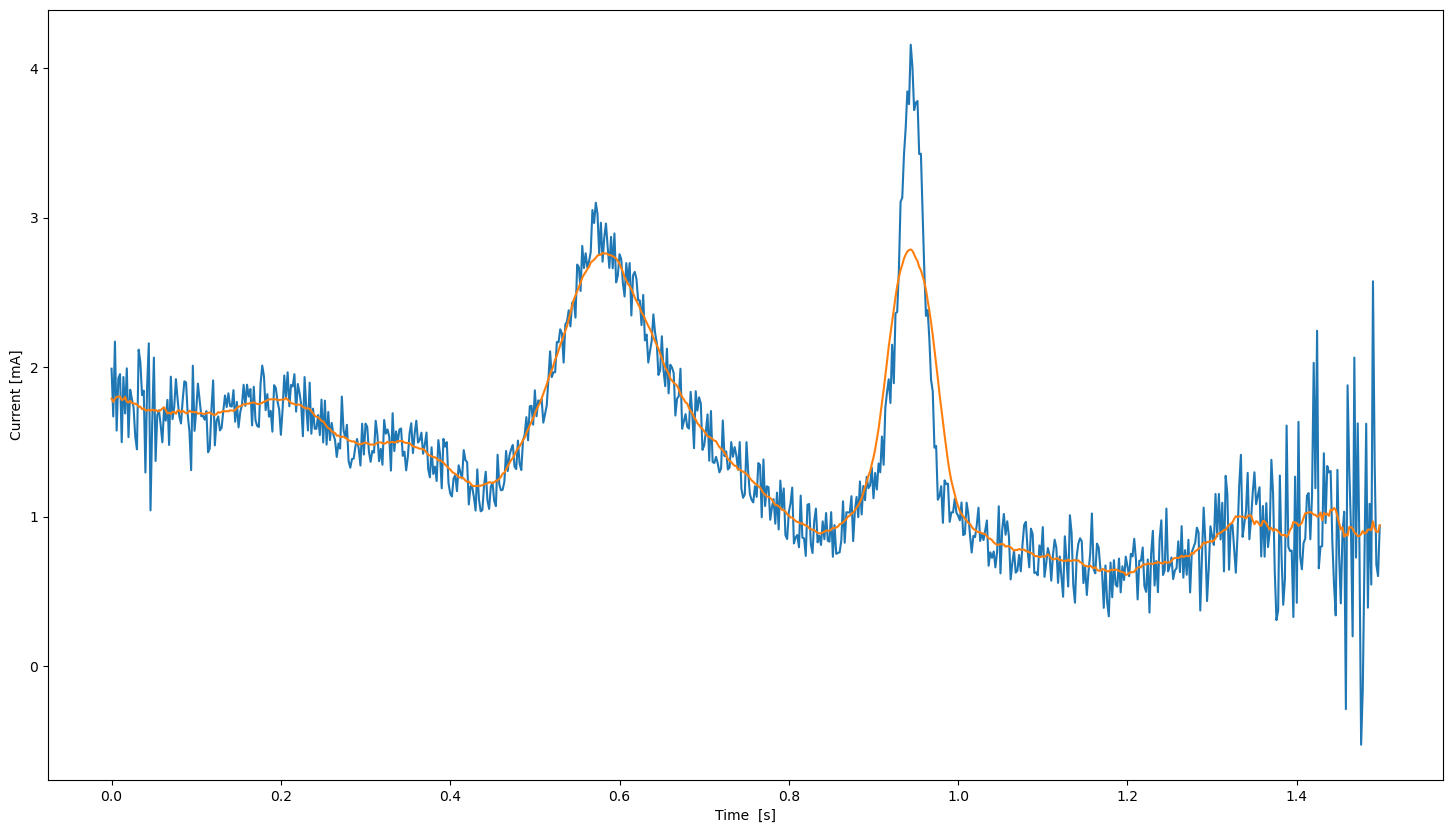

In [26]:
data1 = np.loadtxt('peaks.txt', comments='#', delimiter=' ')
t = data1[:, 0]
I = data1[:, 1]

_, ax = plt.subplots(figsize=(18,10))
ax.set_xlabel('Time  [s]')
ax.set_ylabel('Current [mA]')
ax.plot(t, I)
ax.plot(t, denoise_moving_average(I, 15))

## c)

Bei welchen Frequenzen erwarten Sie eine Änderung im der spektralen Leistungsdichte wenn Sie das gefilterte Signal betrachten?

Berechnen Sie mithilfe der Fouriertransformation die spektrale Leistungsdichte des Originalsignals und des geglätteten Signals. Bestätigt sich Ihre Vermutung? Welchen Einfluss hat der Wert $\Delta$?

Hinweis: Sie müssen die y-Achse logarithmisch plotten oder stark vergrössern um den Effekt zu sehen. Das Spektrum wird ansonsten von den tiefen Frequenzen dominiert, da das Signal grösstenteils konstant ist.

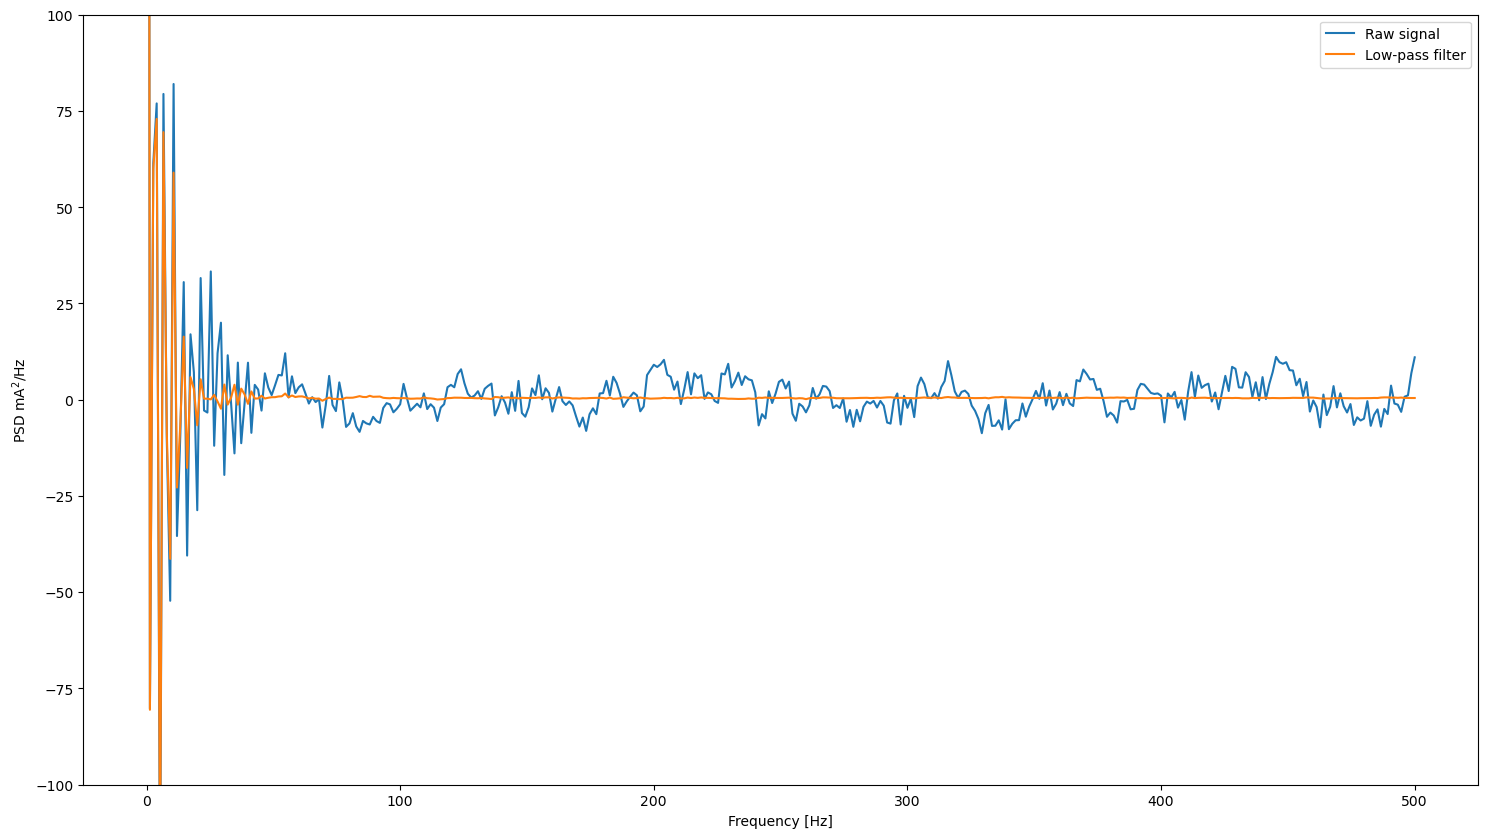

In [142]:
I_flat = denoise_moving_average(I, 20)

_, ax = plt.subplots(figsize=(18,10))
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD mA$^2$/Hz')
ax.plot(np.fft.rfftfreq(len(I), t[1]), np.fft.rfft(I), label='Raw signal')
ax.plot(np.fft.rfftfreq(len(I_flat), t[1]), np.fft.rfft(I_flat), label='Low-pass filter')
ax.set_ylim((-100,100)) # Uncomment to see more
ax.legend()

# Aufgabe 2: Filtern im Frequenzraum

In Aufgabe 1 haben Sie die Daten in der Zeitdomäne gefiltert und gesehen, wie sich das in der Frequenzdomäne wiederspiegelt. In dieser Aufgabe werden Sie die Daten in der Frequenzdomäne filtern und schauen, was der Effekt auf das zeitabhängige Signal ist.

## Hintergrund

In der Vorlesung haben Sie gesehen, dass man für die Bestimmung der Dauer eines kurzen Laserpulses dessen Autokovarianz oder Autokorrelation verwenden kann. Dies ist notwendig, weil Laserpulse viel kürzer (z.B. $150\,\mathrm{fs} = 150\cdot 10^{-15}\,\mathrm{s}$) sein können als die Abtastraten von Detektoren (bis zu GHz, also $\Delta t \sim 1\,\mathrm{ns} = 1\cdot 10^{-9}\,\mathrm{s}$).

In der Datei 'autocorrelation_laser.txt' finden Sie eine Messung der Autokorrelation eines Laserpulses, die mit einem <a href=https://en.wikipedia.org/wiki/Michelson_interferometer>Michelson-Inteferometer</a> durchgeführt wurde. Das gemessene Signal hat die Einheit Volt und ist proportional zur Intensitätsautokorrelation des Laserlichts. Die Zeitachse entspricht der Zeitverzögerung zwischen den zwei Armen des Interferometers und damit der Zeitdifferenz zwischen den Laserpulsen, die miteinander interferieren.

## a)

Laden Sie den Datensatz 'autocorrelation_laser.txt' und berechnen Sie die Fouriertransformation des Signals. Plotten Sie dann sowohl das Signal als Funktion der Zeit, als auch die spektrale Leistungsdichte.

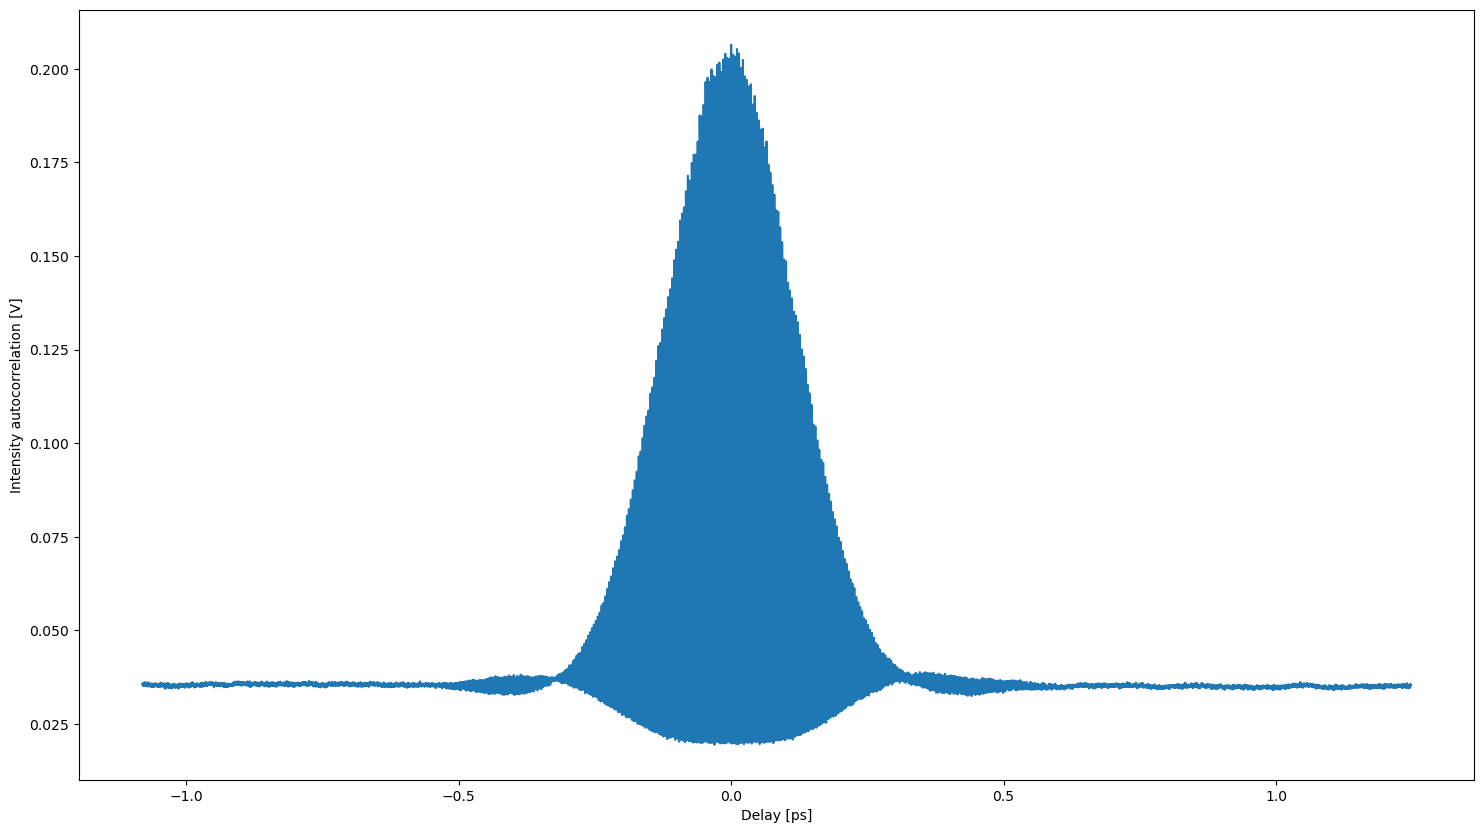

In [59]:
data2 = np.loadtxt('autocorrelation_laser.txt', comments='#', delimiter=' ')
delay = data2[:, 0]
autocor = data2[:, 1]

_, ax = plt.subplots(figsize=(18,10))
ax.set_xlabel('Delay [ps]')
ax.set_ylabel('Intensity autocorrelation [V]')
ax.plot(delay, autocor)

(0.0, 1000.0)

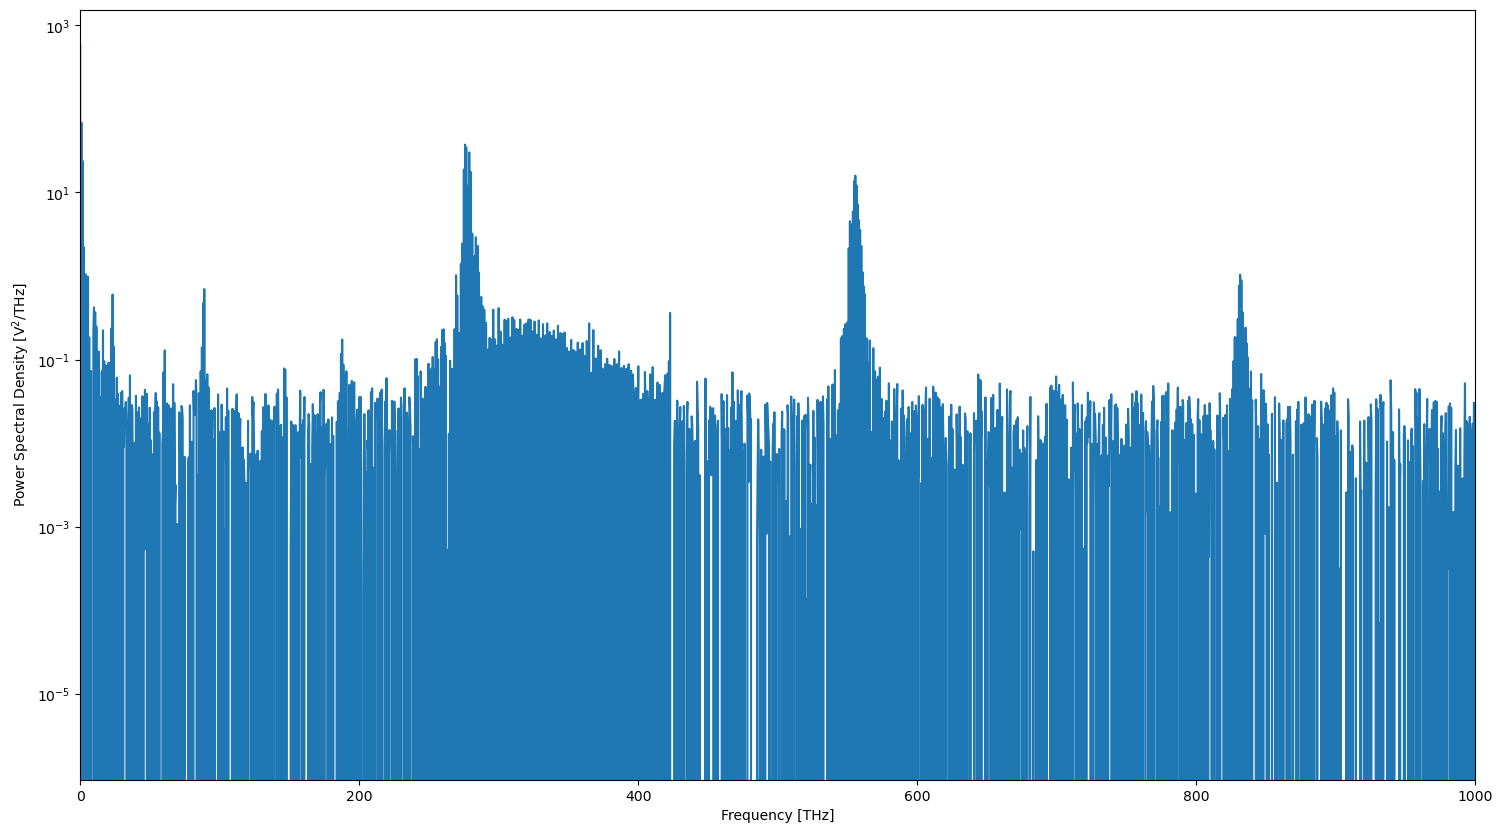

In [143]:
_, ax = plt.subplots(figsize=(18,10))
ax.set_xlabel('Frequency [THz]')
ax.set_ylabel('Power Spectral Density [V$^2$/THz]')
ax.semilogy(np.fft.rfftfreq(len(delay), delay[1]-delay[0]), np.fft.rfft(autocor))
ax.set_xlim((0,1000))

## b)

Berechnen Sie mit `np.fft.ifft` die Fourier-Rücktransformation und plotten Sie es als Funktion der Zeit, um sich zu vergewissern, dass Sie das ursprüngliche Signal rekonstruieren können.

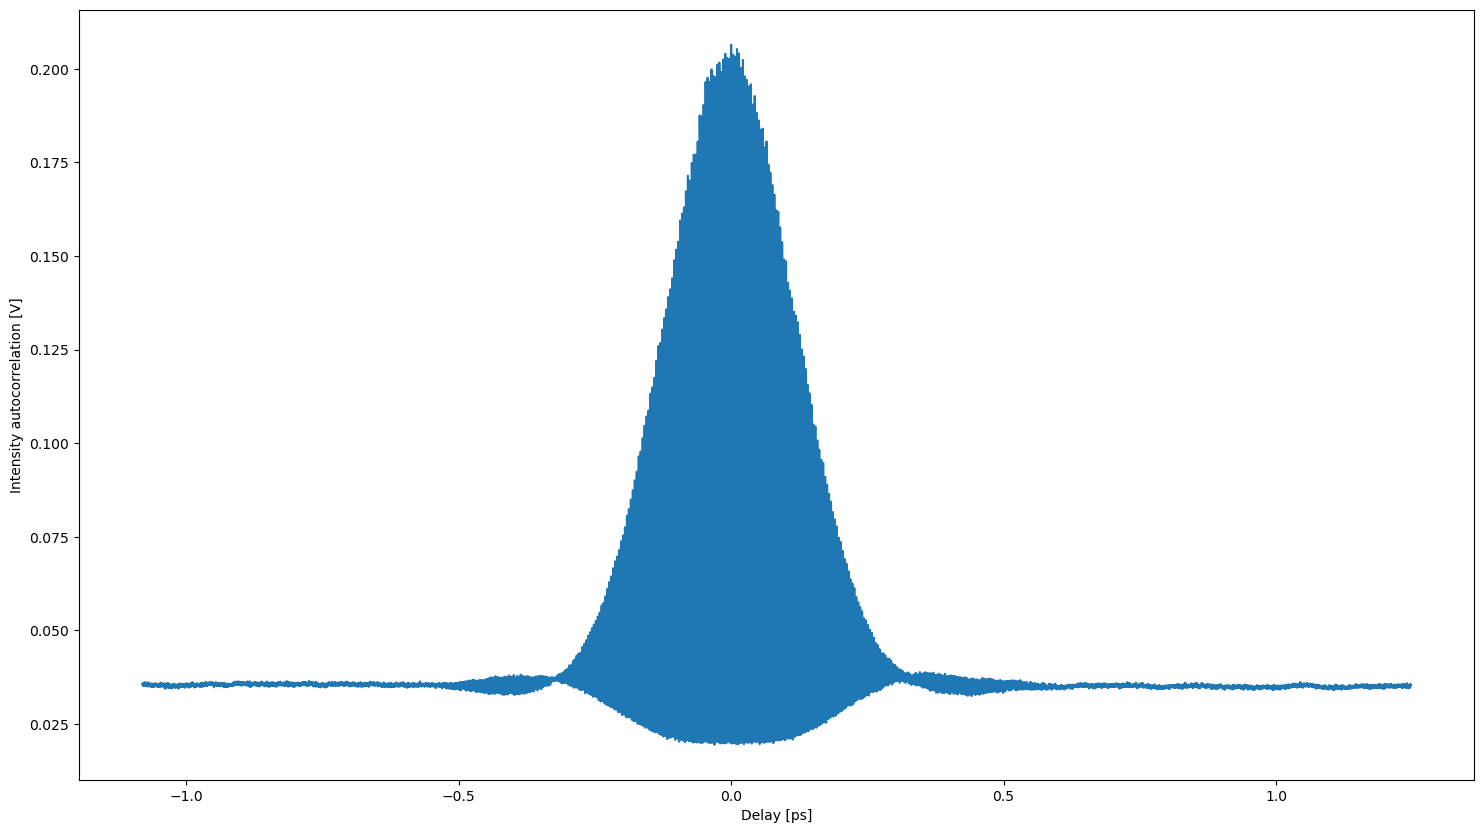

In [74]:
_, ax = plt.subplots(figsize=(18,10))
ax.set_xlabel('Delay [ps]')
ax.set_ylabel('Intensity autocorrelation [V]')
ax.plot(delay, np.fft.irfft(np.fft.rfft(autocor)))

## c)

Schreiben Sie nun eine Funktion, die ein Signal im Frequenzraum filtert und das gefilterte Signal zurückgibt. Die Funktion soll als Argumente ein zeitabhängiges Signal nehmen (Zeitachse $t$, Messwerte $s(t)$), sowie die untere Grenze $f_{\mathrm{min}}$ und obere Grenze $f_{\mathrm{max}}$ eines Frequenzbereichs. Berechnen Sie die Fouriertransformation des Signals und setzen Sie dann alle Frequenzen ausserhalb des Frequenzbereichs $[f_{\mathrm{min}}, f_{\mathrm{max}}]$ auf Null. Das gefilterte Signal erhalten Sie aus der Rücktransformation des modifizierten Spektrums.

Hinweis: Beachten Sie, dass auch negative Frequenzen vorkommen. Daher müssen Sie beim Filtern alle Frequenzen $f_n$ behalten, die 

$$ f_{\mathrm{min}} \leq \left| f_n \right| \leq f_{\mathrm{max}} $$

erfüllen.

In [100]:
def freq_filter(time, data, f_min, f_max):
    ftfreq = np.fft.fftfreq(len(time), time[1]-time[0]) # Assuming constant time differences
    ft = np.fft.fft(data)
    # get indices for f <= -f_max or -f_min <= f <= f_min or f_max <= f
    indices = np.argwhere(np.logical_or(np.logical_or(ftfreq <= -f_max, np.logical_and(-f_min <= ftfreq, ftfreq <= f_min)), f_max <= ftfreq))
    for i in indices:
        ft[i] = 0
    return np.fft.ifft(ft)

## d)

Verwenden Sie Ihre Funktion aus c) um auf das Signal, das Sie in a) geladen haben, einen Tiefpassfilter anzuwenden (d.h. hohe Frequenzen über einem Grenzwert werden herausgefiltert). Plotten Sie das gefilterte Signal als Funktion der Zeit.

Was passiert, wenn Sie statt einem Tiefpassfilter einen Hochpassfilter anwenden (also Frequenzen unter dem Grenzwert herausfiltern)? Welches Signal würden Sie verwenden, um die Länge des Laserpulses zu bestimmen?

Hinweis: Wählen sie den Grenzwert kleiner als die erste endliche Frequenzkomponente des Signals, so dass die oszillierenden und die nicht oszillierenden Teile des Signals getrennt werden.

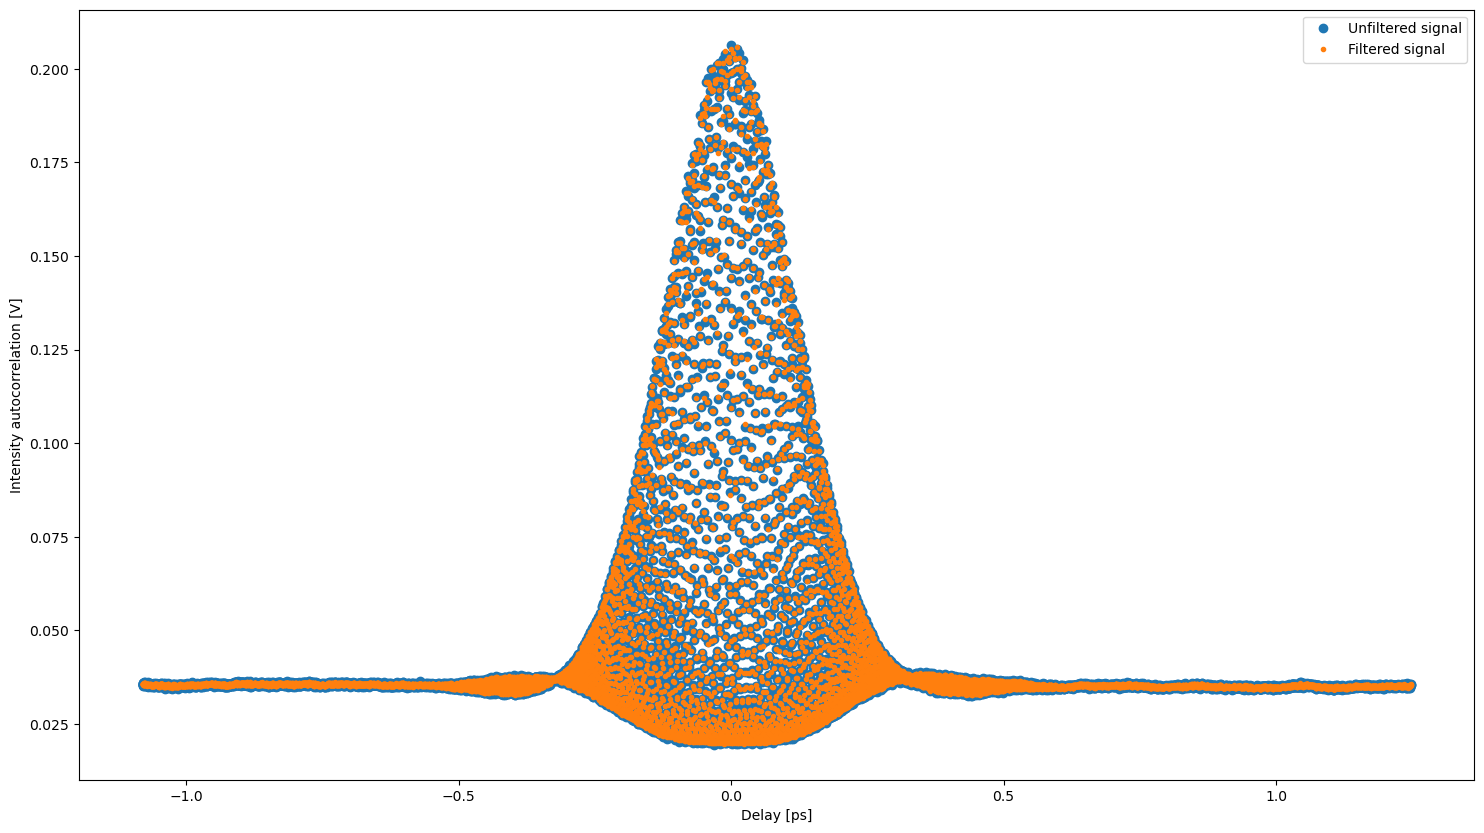

In [123]:
_, ax = plt.subplots(figsize=(18,10))
ax.set_xlabel('Delay [ps]')
ax.set_ylabel('Intensity autocorrelation [V]')
ax.plot(delay, autocor, 'o', label='Unfiltered signal')
ax.plot(delay, freq_filter(delay, autocor, 0, 1000)+0.042, '.', label='Filtered signal')
ax.legend()

## e)

Laden Sie nun den Datensatz "noisy_pulse.txt" und plotten Sie wieder das Signal als Funktion der Zeit und die spektrale Leistungsdichte. Lesen Sie aus dem Spektrum die dominante Frequenzkomponente ab und verwenden Sie Ihre Funktion aus c) um einen Bandpassfilter in diesem Frequenzbereich auf die Daten anzuwenden; d.h. Sie behalten nur die Frequenzen aus einem kleinen Bereich rund um die dominante Frequenzkomponente.

Hinweis: Sie sollten nach Anwenden des Filters eine Oszillation mit einer gaussförmigen Einhüllenden bekommen.

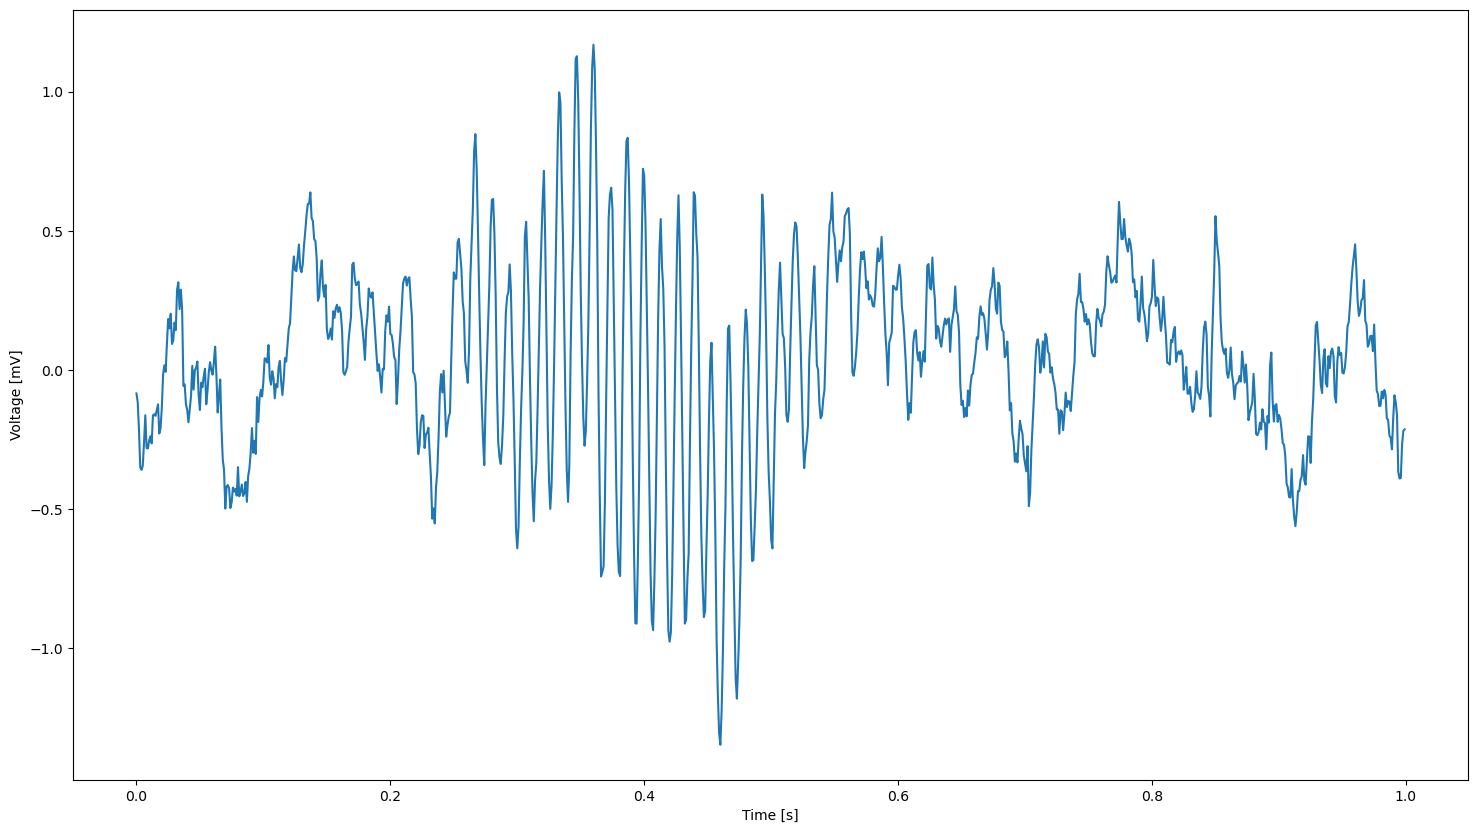

In [124]:
data3 = np.loadtxt('noisy_pulse.txt', comments='#', delimiter=' ')
t = data3[:, 0]
U = data3[:, 1]

ax = plt.subplots(figsize=(18,10))[1]
ax.set_xlabel('Time [s]')
ax.set_ylabel('Voltage [mV]')
ax.plot(t, U)

(50.0, 100.0)

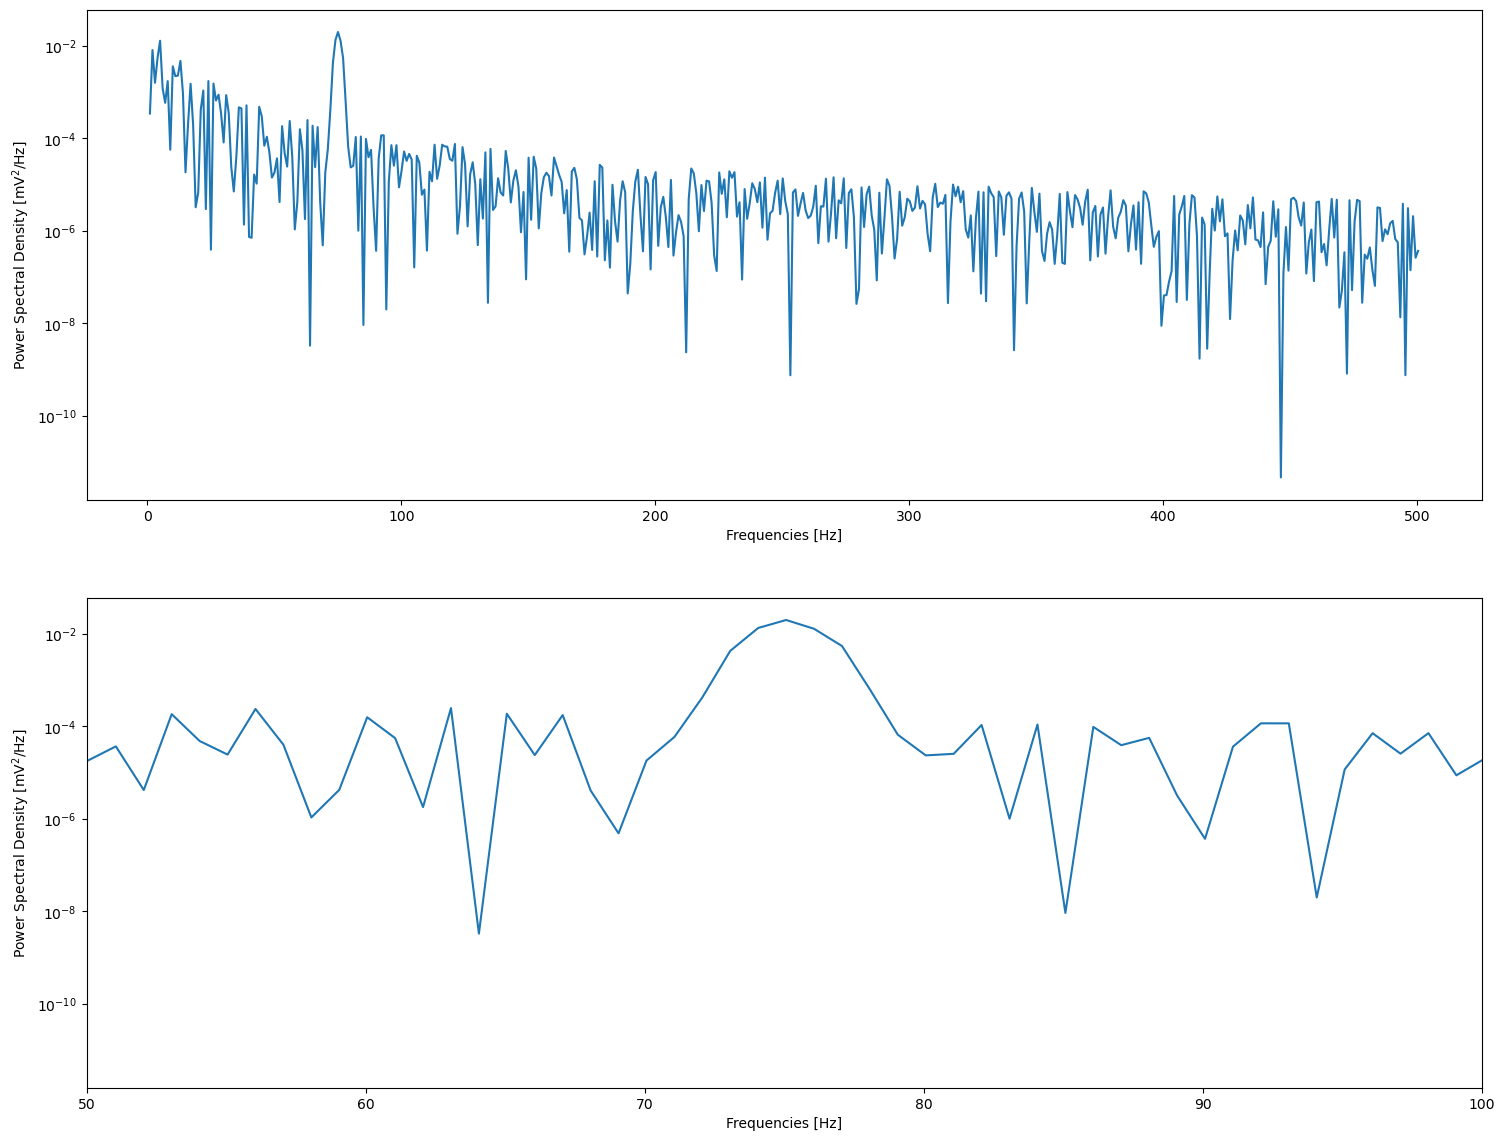

In [144]:
f, psd = sp.signal.periodogram(U, len(t)/t[-1], return_onesided=True, scaling='density')

ax = plt.subplots(2, figsize=(18,14))[1]
ax[0].set_xlabel('Frequencies [Hz]')
ax[0].set_ylabel('Power Spectral Density [mV$^2$/Hz]')
ax[0].semilogy(f[1:], psd[1:])
ax[1].set_xlabel('Frequencies [Hz]')
ax[1].set_ylabel('Power Spectral Density [mV$^2$/Hz]')
ax[1].semilogy(f[1:], psd[1:])
ax[1].set_xlim((50,100))

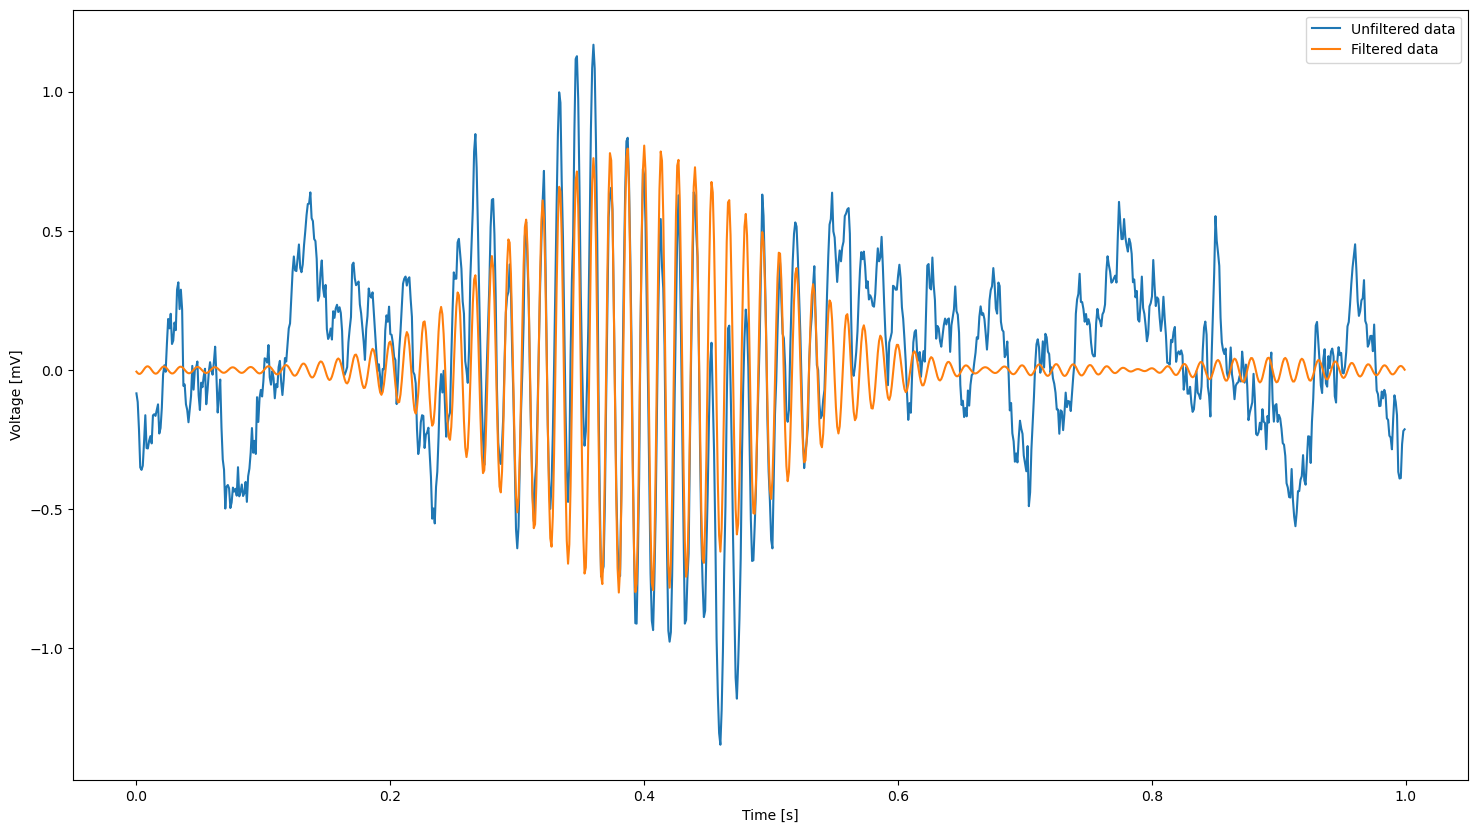

In [145]:
ax = plt.subplots(figsize=(18,10))[1]
ax.set_xlabel('Time [s]')
ax.set_ylabel('Voltage [mV]')
ax.plot(t, U, label='Unfiltered data')
ax.plot(t, freq_filter(t, U, 70, 80), label='Filtered data')
ax.legend()

# Nachbemerkung

Bei all diesen Aufgaben war immer von einem zeitabhängigen Signal die Rede, so dass das Spektrum auch echten Frequenzen entspricht. Allerdings ist dies nicht nötig um diese Methoden anzuwenden; sie funktionieren für jedes Array von Datenpunkten, unabhängig davon, was die x-Achse dazu ist. Tatsächlich waren die Daten aus Aufgabe 1 nicht ein zeitabhängiges Signal, sondern ein optisches Reflexionsspektrum und die x-Achse entspricht in Wirklichkeit einer Wellenlänge. Dennoch kann man die Daten durch Mitteln oder Tiefpassfiltern im Fourier-Raum glätten.